0.084784076121 {'5%': array([ 0.04992119]), '50%': array([ 0.09302378]), '95%': array([ 0.10658913])} 769
6
7
8
9


C:\Users\wesle\FishIsland_Processing\Data_Processor.py:192: RuntimeWarning: invalid value encountered in sqrt
  return(-1/2*theta*(alpha*PPFD+beta-((alpha*PPFD+beta)**2-4*alpha*beta*theta*PPFD)**.5)+\


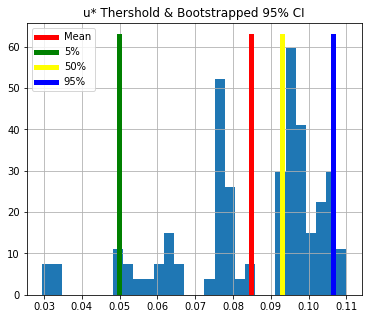

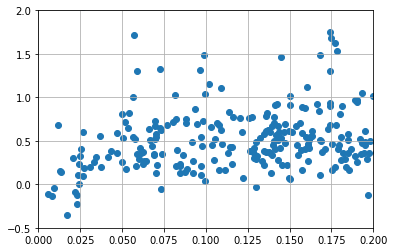

In [43]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as MPR
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from scipy.optimize import curve_fit
from matplotlib.ticker import NullFormatter
import Data_Processor as DP
import importlib
importlib.reload(DP)
# warnings.filterwarnings('ignore')
Root = 'C:/FishIsland_2017/'
FluxFolder='FluxResults/ProperWindSpeeds/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2018-03-25T172145_adv.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2018-03-25T142146_adv.csv'

Met_Path = Root+'MetStationData/CR1000_ClimateData_Updated.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'


Comp = DP.Compile([TenHz_Path,OneHz_Path],Met_Path,Soil_Path)

Drop = [['2017-06-01 15:00:00','2017-06-23 15:00:00'],
['2017-08-28 00:00:00','2017-09-11 16:00:00'],
['2017-09-12 07:30:00','2017-09-12 15:00:00']]
Var = ['All','co2_flux','co2_flux']
for drop,var in zip(Drop,Var):
    Comp.Date_Drop(drop,Vars=var)
    
    
    
    
Periods = [['2017-07-10 15:30:00','2017-08-23 15:00:00'],
           ['2017-06-23 15:00:00','2017-07-10 15:00:00'],
            ['2017-08-23 15:30:00','2017-09-13 23:00:00']]
# Var = ['All','co2_flux','co2_flux']
for i,per in enumerate(Periods):
    Comp.Date_Key(per,i)
    
Comp.Rain_Check([.5,0])

Comp.Wind_Bins(30)
# Comp.PPFD_Bins(100)
    
Comp.QC_Check(2)
Comp.Spike_Removal(z_thresh=5.5)
Comp.StorageCorrection()
Comp.Wind_Filter(30)
Comp.ustar_Bins(30,{'Var':'PPFD_Avg','Thresh':10},{'Var':'co2_flux','Plot':True},
                {'Repetitions':100,'n_samples':10000})
plt.figure()
plt.scatter(Comp.uFilterData['u*'],Comp.uFilterData['fco2'])
plt.ylim(-.5,2)
plt.xlim(0,.2)
plt.grid()

print(Comp.uThresh,Comp.Pct,Comp.uThresh_SampSize)

Comp.Ustar_Drop()
Comp.CustomVars()
Comp.Fco2_Fill('PPFD_Avg','AirTC_Avg')
Vars=['H','LE','Fco2','fco2','fch4','wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg','PPFD_Avg','Rain_mm_Tot',
      'Table_1','Temp_2_5_1','Temp_15_1','VWC_1','Active_Layer_1','24H Rain','Wtr Tbl Trnd','ET','GPP','ER',"NEE",'Dir']
Aliases=['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET','GPP','ER','NEE','Dir']
Comp.Write(Root,Vars,Aliases)

-0.5276230355269345
-0.36974288668164584
-0.36463764944852156


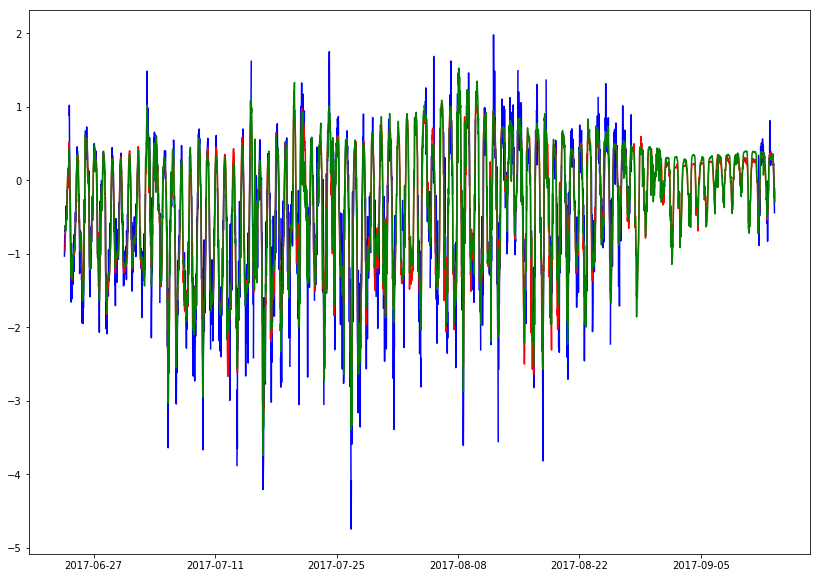

In [55]:

Data = Comp.Data.copy()

CH4 = 'C:/FishIsland_2017/GapFilledfch4.csv'
CO2 = 'C:/FishIsland_2017/GapFilledfco2.csv'
CH4 = pd.read_csv(CH4)
CH4 = CH4.set_index(pd.DatetimeIndex(CH4.datetime))
CO2 = pd.read_csv(CO2)
CO2 = CO2.set_index(pd.DatetimeIndex(CO2.datetime))
Data['fch4']*=1000
Data['Fco2_Standard']=Data['Fco2']*1.0

# print(CO2['Model: Wind Spd+Ta+PPFD+VWC+Active Layer'].mean())
# print(CO2['Fco2'].mean())

plt.figure(figsize = (14,10))
plt.plot(Data['fco2'],color='blue')
plt.plot(CO2['Model: Wind Spd+Ta+PPFD+VWC+Active Layer'],color='red')
plt.plot(CO2['Model: Wind Spd+air pressure+Ta+PPFD+Ts 2.5 cm+Ts 15 cm+VWC+Active Layer+Rain+Water Table'],color='green')
Data['Fch4'] = Data['fch4'].fillna(CH4['Model: Wind Spd+air pressure+PPFD+Active Layer+Water Table'])
Data['Fco2'] = Data['fco2'].fillna(CO2['Model: Wind Spd+Ta+PPFD+VWC+Active Layer'])
# plt.plot(Data['Fco2'],color='yellow')
print(Data['fco2'].mean())
print(Data['Fco2'].mean())
print(Data['Fco2_Standard'].mean())
Data.to_csv('C:/FishIsland_2017/AllData.csv')


In [ ]:
for root,Dir,files in (os.walk(Root+'TagluStationData/Daily/')):
    for i,file in enumerate(files):
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,2,3],na_values='NAN')[0]
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        for V in ['SoilMoist_Avg(1)','SoilMoist_Avg(2)','SoilMoist_Avg(3)','SoilMoist_Avg(4)','SoilMoist_Avg(5)','SoilMoist_Avg(6)']:
            df[V]=pd.to_numeric(df[V])
        if i <= 5:
            df[['SoilMoist_Avg(1)','SoilMoist_Avg(2)','SoilMoist_Avg(3)','SoilMoist_Avg(4)','SoilMoist_Avg(5)','SoilMoist_Avg(6)']]*=100
        if i == 0:
            Daily = df
        else:
            Daily = Daily.append(df)
            


for root,Dir,files in (os.walk(Root+'TagluStationData/Hourly/')):
    for i,file in enumerate(files):
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,1,3],na_values='NAN')[0]
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        for V in ['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']:
            df[V]=pd.to_numeric(df[V])
#         df[['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']] =\
#         pd.to_numeric(df[['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']])
        if i <= 5:
            df[['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']]*=100
        if i == 0:
            Hourly = df
        else:
            Hourly = Hourly.append(df)

Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>1] = np.nan
# Daily['Snow_Depth'] = Daily['Snow_Depth'].ffill()
print(Daily.head())

In [ ]:
Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>.7] = np.nan
Daily['Snow_Depth'].ffill()

Daily2=Hourly.resample('D').mean()
plt.plot(Hourly['SoilMoist(3)'])

Daily2=Daily2.groupby(Daily2.index.dayofyear).mean()
DailyDaily2=Daily.groupby(Daily.index.dayofyear).mean()
# print(Monthly)

# print(Daily.head())

fig,ax = plt.subplots(2,2,figsize=(10,10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

ax1.plot(Daily['AirTemp_Avg'])
ax1.grid()
ax1.set_title('Air Temperature')

ax2.plot(Daily['Net_Ttl_Rad_Avg'])
ax2.grid()
ax2.set_title('Net Radiation')

ax3.plot(Daily['Snow_Depth'])
ax3.set_title('Snow Depth')
# ax3.set_ylim(0,1)
ax3.grid()

# ax4.plot(Daily2['SoilMoist(1)'])
# ax4.plot(Daily2['SoilMoist(2)'])
ax4.plot(Daily['SoilMoist_Avg(1)'])
ax4.grid()
ax4.set_title('Soil Moisture')

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(Daily['Snow_Depth'])